# Data Exploaration

The goal of this notebook is to analyse the twitter data and get some first insights.

In [66]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
twitts = pd.read_csv('../data/Tweets.csv')

## First look

In [4]:
twitts.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
twitts.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [6]:
twitts.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [135]:
twitts.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [131]:
twitts['negativereason_gold'].unique()

array([nan, 'Late Flight\nFlight Attendant Complaints',
       'Late Flight\nLost Luggage', 'Late Flight',
       'Customer Service Issue', "Can't Tell",
       'Cancelled Flight\nCustomer Service Issue', 'Cancelled Flight',
       'Bad Flight', 'Lost Luggage\nDamaged Luggage',
       'Late Flight\nCancelled Flight', 'Flight Attendant Complaints',
       'Customer Service Issue\nLost Luggage',
       "Customer Service Issue\nCan't Tell"], dtype=object)

In [137]:
twitts['tweet_location'].nunique()

3081

## Probably redundant columns
Below is the list of columns which seem to don't have greate impact on the sentiment.  
* *tweet_id* - doesn't matter, it's just an id
* *negativereason* - our goal is to predict the sentiment not the reason of the negative one
* *airline_sentiment_gold* and *negativereason_gold* - **unknown meaning** but they look like another labels
* *airline_sentiment_confidence* - probably confidence of label above
* *tweet_coord* - probably could have some impact (if sent from the airport sentiment would be probably negative) but let's skipped it. It is sparse so there are NaNs which we don't like.
* *tweet_location* - there are 3081 locations - so it's about 20% of the whole data size. This won't gives us much insight
* *user_timezone* - shouldn't be correlated with sentiment


In [142]:
columns_to_drop = [
    'tweet_id', 'negativereason', 'airline_sentiment_gold', 
    'negativereason_gold', 'tweet_coord', 'tweet_location',
    'user_timezone', 'airline_sentiment_confidence'

]

In [143]:
twitts.drop(columns=columns_to_drop).columns

Index(['airline_sentiment', 'negativereason_confidence', 'airline', 'name',
       'retweet_count', 'text', 'tweet_created'],
      dtype='object')

In [9]:
twitts['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [11]:
df = twitts.copy()
df['airline_sentiment'] = df['airline_sentiment'].replace({'negative': -1, 'neutral': 0, 'positive': 1})

## Possible data correlation
There are probably correlation between:  
* the number of tweets of given user about certain airline
* the sentiment and the retweet count

In [115]:
print('Users no.: %d' % df['name'].nunique())
print('Airlines no.: %d' % df['airline'].nunique())

Users no.: 7701
Airlines no.: 6


In [52]:
tmp = df.groupby(['name', 'airline']).size().to_frame()
tmp.columns = ['count']
tmp['avg_airline_sentiment'] = df.groupby(['name', 'airline']).mean()['airline_sentiment']
display(tmp.sort_values(by='count', ascending=False).head())

print('Average sentiment for more than 5 twitts: %s' % tmp[tmp['count'] > 5]['avg_airline_sentiment'].mean())

,,count,avg_airline_sentiment
name,airline,,
JetBlueNews,Delta,62,0.064516
kbosspotter,Delta,32,0.062500
otisday,American,28,-1.000000
throthra,United,27,-0.851852
rossj987,US Airways,23,-1.000000


Average sentiment for more than 5 twitts: -0.6629313127706453


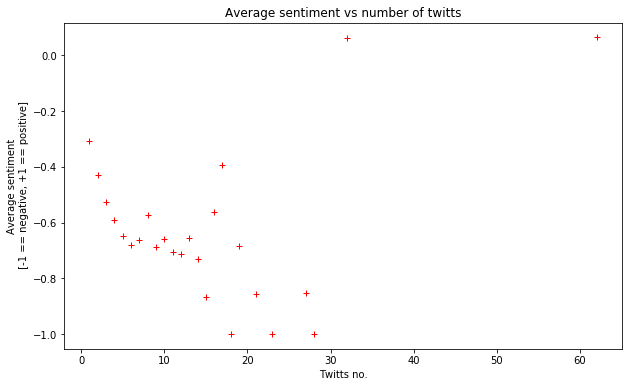

In [119]:
plot_boundaries = tmp['count'].unique()
avg_sentiment = []
minimum = 0

for item in plot_boundaries:
    tmp_chunk = tmp[tmp['count'] == item]
    avg_sentiment.append(tmp_chunk['avg_airline_sentiment'].mean())

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(plot_boundaries, avg_sentiment, '+r')
ax.set(xlabel='Twitts no.', ylabel='Average sentiment\n [-1 == negative, +1 == positive]',
       title='Average sentiment vs number of twitts')
plt.show()

As we can see the more twitts user has published the more negative sentiment is.  
Of course there are some neutral examples but its probably caused by resolving the problem by the airline company.

In [114]:
df['retweet_count'].nunique()

18

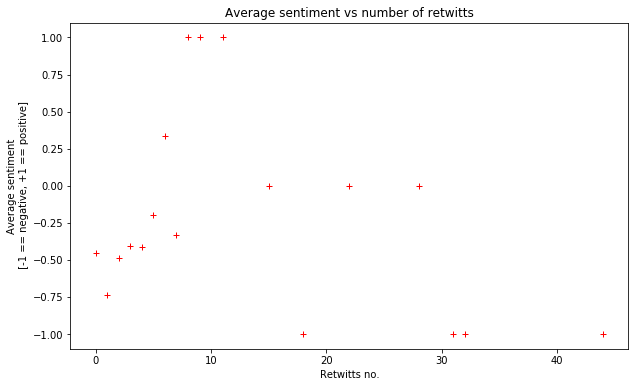

In [127]:
avg_sentiment = []
retweet_counts = df['retweet_count'].unique()
for retweet_count in retweet_counts:
    tmp_chunk = df[df['retweet_count'] == retweet_count]
    avg_sentiment.append(tmp_chunk['airline_sentiment'].mean())
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(retweet_counts, avg_sentiment, '+r')
ax.set(xlabel='Retwitts no.', ylabel='Average sentiment\n [-1 == negative, +1 == positive]',
       title='Average sentiment vs number of retwitts')
plt.show()

It's clear that positive sentiments aren't so viral as negative ones - positive ones has only up to 15 retweets, when the opposite have even up to 45.  
Unfortunately there aren't clear boundary between groups and it seems that using number of retweets can be not the best feature.